<a href="https://colab.research.google.com/github/davidhinostroza/TFM_ChestX_Pneumonia/blob/master/TFM_Chest_GPU_VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ![texto alternativo](https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTZmBG5MR7QjdesSPQHy6nFwI7kKMBp6odP36zK1IdhoxEYyDa0) **GPU**




# Objetivo Proyecto TFM Deep Learning Rayos X del torax TPU.

Clasificar y detectar las enfermedades humanas a partir de las imagenes medicas de rayos X del torax como la Neumonia.
Para ello vamos a utilizar tecnologia google (unidad de procesamiento tensorial) TPU para comparar modelos binarios , Curvas Roc , matriz de confusión y comparar con un modelo pre-computado vs el modelo.


# Contexto
​
![texto alternativo](https://i.imgur.com/jZqpV51.png) 
​
### (imagen sustraida de Kaggle 
​
​
Tenemos images ilustrativos de radiografías de tórax en pacientes de neumonía. 
La radiografía de tórax normal (panel izquierdo) muestra los pulmones claros sin áreas opacas en la imagen del torax. 
La neumonía bacteriana (centro) exhibe una infección, en este caso en el lóbulo superior derecho (flechas blancas).
Mientras que la neumonía viral (derecha) se manifiesta con un patrón más difuso e "intersticial" en ambos pulmones.

Para ello construiremos un modelo de clasificación de imagen con Keras y tensorflow deep learning con tecnología TPU (unidad de procesamiento tensorial) donde utilizaremos modelo de tipo categórico con mediciones :


*   Matriz de confusión.
*   Curvas ROC AUC
*   Curvas ROC RECALL

Y se compara una red pre-computada para clasificación de imagen vs el modelo. 

# **Datos y Clasificación**

El conjunto de datos está organizado en 3 carpetas (train, test, val) y contiene subcarpetas para cada categoría de imagen (Pneumonia / Normal). 

Hay 5.863 imágenes de rayos X (JPEG) y 2 categorías (neumonía / normal).
Antes de cargar las imagenes tendre que etiquetarlas de la siguiente manera :							
- Tórax normal      = 0	
- Tórax Neumonia = 1

Fuente de datos : 

http://www.cell.com/cell/fulltext/S0092-8674(18)30154-5

https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

# **Arquitectura**


*   Google Colab Free TPU
*   Google Colab Free GPU
*   Python
*   Pandas
*   Keras

# Instalación del entorno


In [518]:
!pip install keras

# Datos guardados en Google Drive

Para ello es necesario darle click al enlace donde obtendrás un token de seguridad al ejecutarse la linea posterior.

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [520]:
# A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz

!rm -f t*.zip
!rm -f -r dog*
!rm -f -r ches*
!ls -hl

total 2.9M
-rw-r--r-- 1 root root 2.6K Jan 18 16:50 adc.json
drwxr-xr-x 1 root root 4.0K Jan  8 17:15 sample_data
-rw-r--r-- 1 root root 2.9M Jan 18 19:49 val.zip


In [0]:
# Download a file based on its file ID.
#

file_id = '1QXMJH_H3T-GdCA4CvReNbP7UdRw7OpnV'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("train.zip")

file_id = '1X0Ux_dC7OlNLBH50gFTkMZ_Wl1hJ4RaJ'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("test.zip")

file_id = '1Xi9wcxrSwKa0jIh9XsNungBWHSCdxMOF'
downloaded = drive.CreateFile({'id': file_id})
downloaded.GetContentFile("val.zip")

# Descompresión de las carpetas

!mkdir chestX
!cd chestX && unzip -q ../train.zip
!cd chestX && unzip -q ../test.zip
!cd chestX && unzip -q ../val.zip

# Librerías a utilizar (Red precomputada VGG16)

In [0]:
from keras.applications.vgg16 import VGG16
from keras.applications.resnet50 import ResNet50
from keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import binary_accuracy
from tensorflow.keras.layers import Dense,Activation,BatchNormalization,MaxPooling2D,Conv2D,Flatten,Dropout,MaxPool2D,Softmax,Input
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score,classification_report, confusion_matrix
from tqdm import tqdm  
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
import tensorflow as tf
import random
import keras.backend.tensorflow_backend as K
    

# Crear modelo VGG16 precomputado

In [523]:
conv_base= VGG16( weights='imagenet', include_top=False, input_shape=(75,75,3),input_tensor=None, pooling=None, classes=2)
conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_21 (InputLayer)        (None, 75, 75, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 75, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 75, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 37, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 37, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 37, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 18, 128)       0         
__________

# Configuración de las imágenes

In [0]:
conv_base.trainable=False

In [525]:
from tensorflow.keras import backend as K

img_width, img_height = 75, 75

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)
    
input_shape

(75, 75, 3)

# Agregar capas al modelo precomputado

In [526]:
from keras import models
from keras import layers
m = models.Sequential()
m.add(conv_base)
m.add(layers.Flatten())
m.add(layers.Dense(1024, activation='relu'))
m.add(layers.Dropout(0.5))
m.add(layers.Dense(512, activation='relu'))
m.add(layers.Dropout(0.4))
m.add(layers.Dense(256, activation='relu'))
m.add(layers.Dropout(0.3))
m.add(layers.Dense(2, activation='softmax'))

m.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_16 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dense_48 (Dense)             (None, 1024)              2098176   
_________________________________________________________________
dropout_34 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_49 (Dense)             (None, 512)               524800    
_________________________________________________________________
dropout_35 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_50 (Dense)             (None, 256)               131328    
__________

# Compìlación del modelo

In [0]:
#ahora compilamos el modelo
m.compile(
    optimizer = tf.train.AdamOptimizer(learning_rate=0.0001),
    loss = tf.keras.losses.categorical_crossentropy,
    metrics=['accuracy'])


# Generación de lotes de imágenes


Generar lotes de datos tensor de imágenes con aumento de datos en tiempo real. Los datos se pasarán (en lotes).

In [528]:
#Generadores Genericos que cojan las imagenes del disco
from sklearn.metrics import roc_auc_score,roc_curve,accuracy_score,recall_score
from keras.metrics import categorical_accuracy
from keras.preprocessing import image
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator

#Generadores Genericos que cojan las imagenes del disco
from keras.preprocessing import image
train_datagen=image.ImageDataGenerator(rescale=1./255.0, shear_range=0.2,zoom_range=0.2, horizontal_flip=True)
validation_datagen=image.ImageDataGenerator(rescale=1./255.0, shear_range=0.2,zoom_range=0.2, horizontal_flip=True)
test_datagen=image.ImageDataGenerator(rescale=1./255.0)

gen = ImageDataGenerator()
train_batches = train_datagen.flow_from_directory("../content/chestX/train/",target_size=(75,75),batch_size=30)
valid_batches = gen.flow_from_directory("../content/chestX/val/", target_size=(75,75), batch_size=30)
test_batches = test_datagen.flow_from_directory("../content/chestX/test/", target_size=(75,75), batch_size=30)

Found 5232 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


# Ejecución del modelo

In [529]:
h= m.fit_generator(train_batches,epochs=20, steps_per_epoch=50, validation_data= test_batches, validation_steps=50)

Epoch 1/20
50/50 [==============================] - 72s 1s/step - loss: 0.5748 - acc: 0.7213 - val_loss: 0.4578 - val_acc: 0.8118
Epoch 2/20
50/50 [==============================] - 33s 656ms/step - loss: 0.3885 - acc: 0.8300 - val_loss: 0.3657 - val_acc: 0.8649
Epoch 3/20
50/50 [==============================] - 34s 678ms/step - loss: 0.3217 - acc: 0.8640 - val_loss: 0.3546 - val_acc: 0.8381
Epoch 4/20
50/50 [==============================] - 34s 686ms/step - loss: 0.2944 - acc: 0.8710 - val_loss: 0.3419 - val_acc: 0.8676
Epoch 5/20
50/50 [==============================] - 35s 706ms/step - loss: 0.2371 - acc: 0.9027 - val_loss: 0.2980 - val_acc: 0.8770
Epoch 6/20
50/50 [==============================] - 35s 703ms/step - loss: 0.2614 - acc: 0.8947 - val_loss: 0.3089 - val_acc: 0.8812
Epoch 7/20
50/50 [==============================] - 33s 660ms/step - loss: 0.2594 - acc: 0.8900 - val_loss: 0.3576 - val_acc: 0.8602
Epoch 8/20
50/50 [==============================] - 34s 687ms/step - los

# Predecir el modelo con los datos de test

Convertimos los datos predecidos a un dataFrame y calculamos la precisión.

In [530]:
no_steps = len(test_batches)
p = m.predict_generator(test_batches,steps=no_steps,verbose=True)
pre = pd.DataFrame(p)
pre['item']=pre.reset_index().index
pre["filename"] = test_batches.filenames
pre["label"] = (pre["filename"].str.contains("PNEUMONIA")).apply(int)
pre['pre'] = (pre[1]>0.5).apply(int)
accuracy_score(pre["label"], pre["pre"])


21/21 [==============================] - 21s 984ms/step


0.532051282051282

# Función para pintar las metricas.

In [0]:
def plot_metric(history, metric):
    history_dict = history.history
    values = history_dict[metric]
    if 'val_' + metric in history_dict.keys():  
        val_values = history_dict['val_' + metric]

    epochs = range(1, len(values) + 1)

    if 'val_' + metric in history_dict.keys():  
        plt.plot(epochs, val_values, label='Validation')
    plt.semilogy(epochs, values, label='Training')

    if 'val_' + metric in history_dict.keys():  
        plt.title('Training and validation %s' % metric)
    else:
        plt.title('Training %s' % metric)
    plt.xlabel('Epochs')
    plt.ylabel(metric.capitalize())
    plt.legend()
    plt.grid()

    plt.show() 

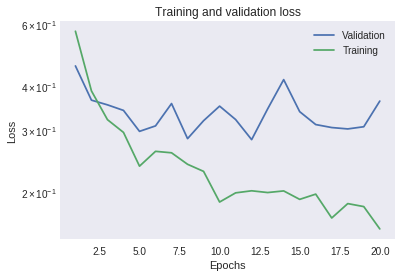

In [532]:
plot_metric(h,'loss')

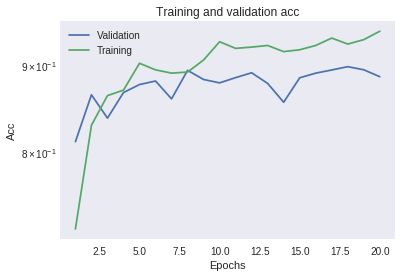

In [533]:
plot_metric(h,'acc')

# Listado de las 20 primeras predicciones guardadas en el dataFrame.

In [534]:
pre[:20]

,0,1,item,filename,label,pre
0,0.000050,0.999950,0,NORMAL/IM-0001-0001.jpeg,0,1
1,0.008963,0.991037,1,NORMAL/IM-0003-0001.jpeg,0,1
2,0.028819,0.971181,2,NORMAL/IM-0005-0001.jpeg,0,1
3,0.122760,0.877240,3,NORMAL/IM-0006-0001.jpeg,0,1
4,0.033057,0.966943,4,NORMAL/IM-0007-0001.jpeg,0,1
5,0.990253,0.009747,5,NORMAL/IM-0009-0001.jpeg,0,0
6,0.001158,0.998842,6,NORMAL/IM-0010-0001.jpeg,0,1
7,0.008117,0.991883,7,NORMAL/IM-0011-0001-0001.jpeg,0,1
8,0.862115,0.137885,8,NORMAL/IM-0011-0001-0002.jpeg,0,0
9,0.952295,0.047705,9,NORMAL/IM-0011-0001.jpeg,0,0


# Visualización de una predicción Erronea ( Registro 16)

Es un pulmón normal pero se predice con Neumonia.

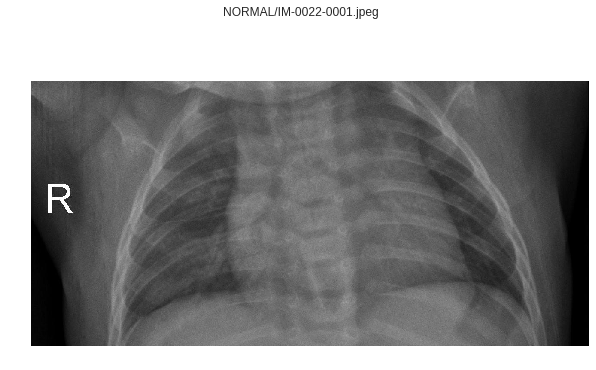

In [535]:
N=16
pre["filename"][N]
import cv2
f,ax = plt.subplots(1,1,figsize=(10,6))
im = cv2.imread('../content/chestX/test/'+pre["filename"][N])
ax.imshow(im)
ax.axis('off')
f.suptitle(pre["filename"][N])
plt.show()

# Mostrar la matriz de predicción

[[ 66 168]
 [124 266]]


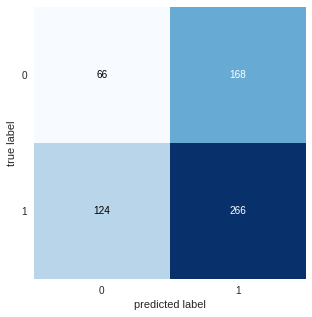

In [536]:
from sklearn.metrics import confusion_matrix
CM = confusion_matrix(pre["label"], pre["pre"])
print(CM)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

# Calcular la precisión y Recall.

In [537]:
# Calculate Precision and Recall
tn, fp, fn, tp = CM.ravel()

precision = tp/(tp+fp)
recall = tp/(tp+fn)

print("Recall of the model is {:.2f}".format(recall))
print("Precision of the model is {:.2f}".format(precision))

Recall of the model is 0.68
Precision of the model is 0.61


# Array de predicciones erróneas

In [0]:
wrong=np.where(pre['pre']!=pre['label'])[0]

In [539]:
wrong

array([  0,   1,   2,   3,   4,   6,   7,  10,  11,  12,  13,  15,  16,
        17,  18,  19,  21,  23,  24,  25,  26,  27,  28,  29,  30,  31,
        32,  33,  36,  37,  38,  39,  40,  41,  42,  44,  49,  50,  51,
        52,  53,  54,  55,  56,  58,  60,  61,  62,  63,  64,  66,  67,
        68,  70,  71,  77,  78,  81,  83,  84,  85,  87,  88,  90,  93,
        94,  95,  96,  97,  98,  99, 102, 103, 104, 105, 107, 108, 109,
       111, 112, 113, 114, 117, 119, 120, 121, 124, 125, 127, 129, 130,
       131, 133, 134, 135, 136, 137, 138, 140, 141, 142, 143, 145, 146,
       148, 149, 151, 152, 153, 155, 156, 157, 158, 159, 161, 163, 165,
       167, 168, 170, 171, 172, 173, 174, 175, 176, 179, 180, 182, 185,
       186, 187, 188, 189, 190, 191, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 203, 204, 205, 207, 208, 209, 211, 214, 215, 216, 218,
       219, 220, 223, 224, 225, 226, 227, 229, 230, 231, 232, 233, 245,
       247, 248, 249, 251, 258, 260, 261, 264, 265, 267, 271, 27

In [540]:
len(wrong)

292

In [0]:
df_wrong=pre.loc[pre.item.isin(wrong)]

# Visualizar al azar las predicciones del modelo.

    item                               filename         0         1  label  pre
0    533      PNEUMONIA/person52_virus_106.jpeg  0.000525  0.999475      1    1
1    182       NORMAL/NORMAL2-IM-0316-0001.jpeg  0.002631  0.997369      0    1
2    514       PNEUMONIA/person38_virus_83.jpeg  0.226323  0.773678      1    1
3     38               NORMAL/IM-0061-0001.jpeg  0.001899  0.998101      0    1
4    342  PNEUMONIA/person136_bacteria_649.jpeg  0.990253  0.009747      1    0
5    577   PNEUMONIA/person82_bacteria_402.jpeg  0.541656  0.458344      1    0
6    605   PNEUMONIA/person91_bacteria_445.jpeg  0.859582  0.140418      1    0
7    504       PNEUMONIA/person28_virus_63.jpeg  0.000172  0.999828      1    1
8     72       NORMAL/NORMAL2-IM-0019-0001.jpeg  0.946606  0.053394      0    0
9    379       PNEUMONIA/person14_virus_44.jpeg  0.887563  0.112437      1    0
10   102       NORMAL/NORMAL2-IM-0112-0001.jpeg  0.058305  0.941695      0    1
11    77       NORMAL/NORMAL2-IM-0030-00

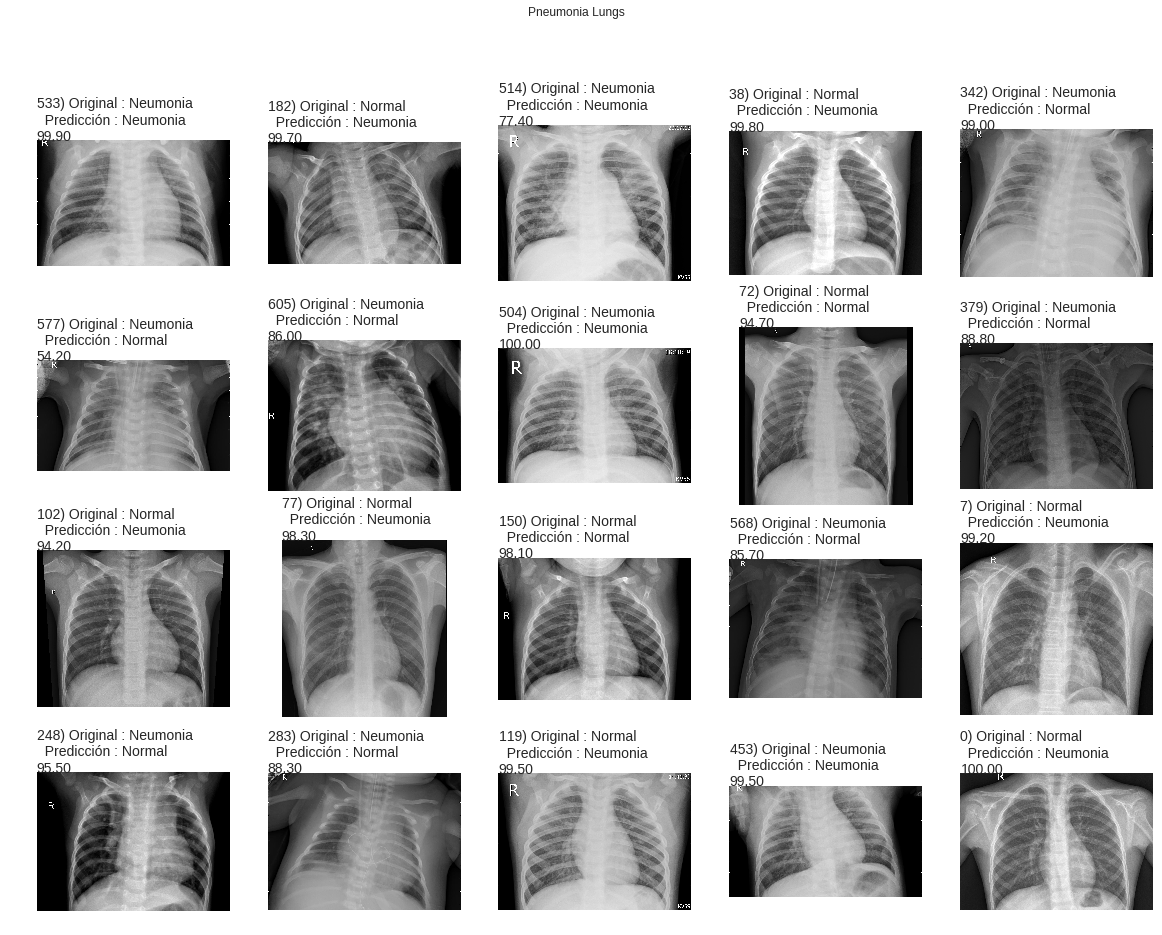

In [544]:
num=20
LABEL_NAMES = ['Normal', 'Neumonia']
#sample_pneumonia = random.sample(list(pre["filename"]),6)
df = pd.DataFrame(random.sample(list(pre['item']),num),columns = ["item"])
sample_pneumonia = pd.merge(df,pre[['item','filename',0,1,'label','pre']],on='item')#.sort_index('item')
sample_pneumonia[:20]
pd.set_option('display.expand_frame_repr', False)
print(sample_pneumonia)
f,ax = plt.subplots(4,5,figsize=(20,15))
for i in range(0,num):
    im = cv2.imread('../content/chestX/test/'+sample_pneumonia['filename'][i])
    #print(im)
    ax[i//5,i%5].imshow(im)
    ax[i//5,i%5].axis('off')
    prediction=sample_pneumonia['pre'][i]
    label = LABEL_NAMES[sample_pneumonia['label'][i]]
    label_predict = LABEL_NAMES[sample_pneumonia['pre'][i]]
    confidence = round(sample_pneumonia[prediction][i]*100,1)
    item= sample_pneumonia['item'][i]
    ax[i//5,i%5].text(0.4, 0.4, str(item)+') ' + 'Original : ' +label + '\n' +'  Predicción : ' +label_predict + '\n%.2f' % confidence, fontsize=14)
f.suptitle('Pneumonia Lungs')
 
plt.show()

# Visualizar al azar las predicciones Erroneas del modelo.

    item                               filename         0         1  label  pre
0    474  PNEUMONIA/person171_bacteria_826.jpeg  0.758155  0.241845      1    0
1    167       NORMAL/NORMAL2-IM-0294-0001.jpeg  0.003731  0.996269      0    1
2     55               NORMAL/IM-0089-0001.jpeg  0.003053  0.996947      0    1
3     19               NORMAL/IM-0027-0001.jpeg  0.313780  0.686220      0    1
4    410   PNEUMONIA/person1614_virus_2800.jpeg  0.539113  0.460887      1    0
5    602        PNEUMONIA/person8_virus_28.jpeg  0.867445  0.132555      1    0
6      6               NORMAL/IM-0010-0001.jpeg  0.001158  0.998842      0    1
7     58               NORMAL/IM-0095-0001.jpeg  0.030184  0.969816      0    1
8    204       NORMAL/NORMAL2-IM-0343-0001.jpeg  0.017250  0.982750      0    1
9    148       NORMAL/NORMAL2-IM-0272-0001.jpeg  0.001521  0.998479      0    1
10   224       NORMAL/NORMAL2-IM-0370-0001.jpeg  0.047431  0.952569      0    1
11   609   PNEUMONIA/person91_bacteria_4

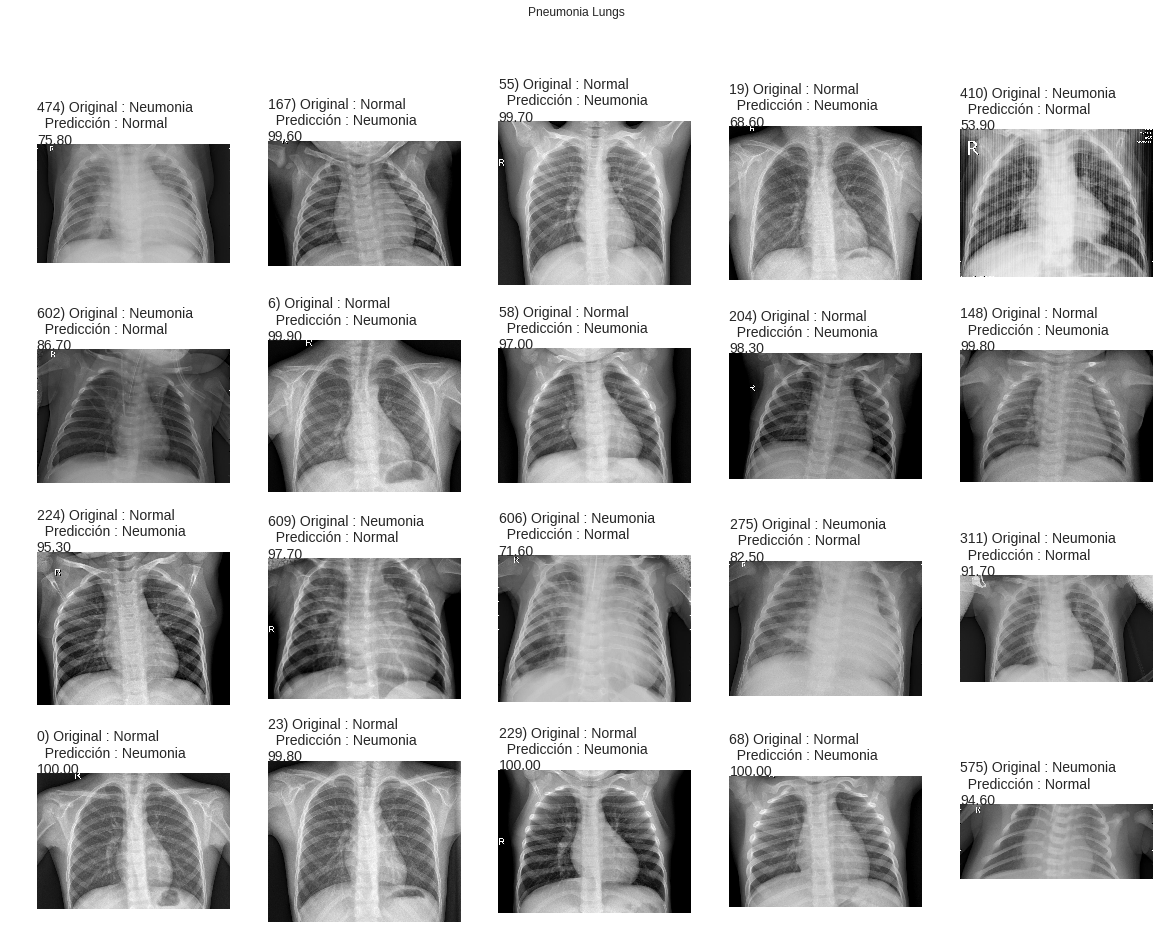

In [545]:
#pre.loc[pre.item.isin(wrong)][:2]

num=20
LABEL_NAMES = ['Normal', 'Neumonia']
#sample_pneumonia = random.sample(list(pre["filename"]),6)
df = pd.DataFrame(random.sample(list(pre.loc[pre.item.isin(wrong)]['item']),num),columns = ["item"])
sample_pneumonia = pd.merge(df,pre[['item','filename',0,1,'label','pre']],on='item')#.sort_index('item')
#sample_pneumonia=pre.loc[pre.item.isin(wrong)]
pd.set_option('display.expand_frame_repr', False)
print(sample_pneumonia)
f,ax = plt.subplots(4,5,figsize=(20,15))
for i in range(0,num):
    im = cv2.imread('../content/chestX/test/'+sample_pneumonia['filename'][i])
    #print(im)
    ax[i//5,i%5].imshow(im)
    ax[i//5,i%5].axis('off')
    prediction=sample_pneumonia['pre'][i]
    label = LABEL_NAMES[sample_pneumonia['label'][i]]
    label_predict = LABEL_NAMES[sample_pneumonia['pre'][i]]
    confidence = round(sample_pneumonia[prediction][i]*100,1)
    item= sample_pneumonia['item'][i]
    ax[i//5,i%5].text(0.4, 0.4, str(item)+') ' + 'Original : ' +label + '\n' +'  Predicción : ' +label_predict + '\n%.2f' % confidence, fontsize=14)
f.suptitle('Pneumonia Lungs')
 
plt.show()

# Calculo de metricas

In [0]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.metrics import f1_score

from matplotlib import pyplot

# El área bajo la curva ROC (AUC)

In [0]:
# calculate AUC
auc = roc_auc_score(pre["label"], pre["pre"])

In [548]:
print('AUC: %.3f' % auc)

AUC: 0.482


In [0]:
# calculate roc curve
fpr, tpr, thresholds = roc_curve(pre["label"], pre["pre"])

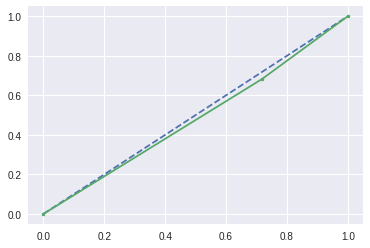

In [550]:
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

## **RECALL ROC**

In [0]:
# calculate precision-recall curve
precision, recall, thresholds = precision_recall_curve(pre["label"], pre["pre"])

f1=0.646 auc=0.482 ap=0.617


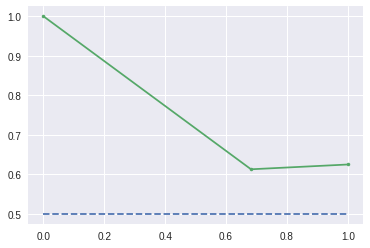

In [552]:
# calculate F1 score
#
f1 = f1_score( pre["label"], pre["pre"])
# calculate precision-recall AUC
#auc = auc(recall, precision)
# calculate average precision score
ap = average_precision_score(pre["label"], pre["pre"])
print('f1=%.3f auc=%.3f ap=%.3f' % (f1, auc, ap))
# plot no skill
pyplot.plot([0, 1], [0.5, 0.5], linestyle='--')
# plot the roc curve for the model
pyplot.plot(recall, precision, marker='.')
# show the plot
pyplot.show()